# Búsqueda de Imágenes Similares Basado en su Contenido (CBIR)

Autores: Joaquín Zepeda V. / Benjamín Irarrázabal T.

En el siguiente notebook se tiene como objetivo desarrollar e implementar un algoritmo CBIR utilizando las bases de datos de INRIA Holidays dataset y GPR1200. \\
En este, se trabajará con dos extractores de características distintos, uno clásico (HOG) y una red convolucional pre entrenada(VGG16). Luego, usando una medida de similitud (Distancia Euclidiana) y dos tipos de ranking definidos se tomarán los resultados obtenidos. 

# Importamos Librerías Importantes

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import numpy as np

# Descargar Bases de Datos de INRIA Holidays dataset

In [2]:
!mkdir jpg1
%cd /content/jpg1
!wget ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz
!tar -xf jpg1.tar.gz

/content/jpg1
--2022-07-13 02:48:33--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz
           => ‘jpg1.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg1.tar.gz ... 1141827194
==> PASV ... done.    ==> RETR jpg1.tar.gz ... done.
Length: 1141827194 (1.1G) (unauthoritative)

jpg1.tar.gz         100%[===================>]   1.06G  11.3MB/s    in 91s     

2022-07-13 02:50:05 (12.0 MB/s) - ‘jpg1.tar.gz’ saved [1141827194]



In [3]:
%cd ..
!mkdir jpg2
%cd /content/jpg2
!wget ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz
!tar -xf jpg2.tar.gz
%cd ..

/content
/content/jpg2
--2022-07-13 02:50:17--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz
           => ‘jpg2.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg2.tar.gz ... 1701364177
==> PASV ... done.    ==> RETR jpg2.tar.gz ... done.
Length: 1701364177 (1.6G) (unauthoritative)

jpg2.tar.gz         100%[===================>]   1.58G  15.9MB/s    in 2m 7s   

2022-07-13 02:52:26 (12.8 MB/s) - ‘jpg2.tar.gz’ saved [1701364177]

/content


# Ejemplo

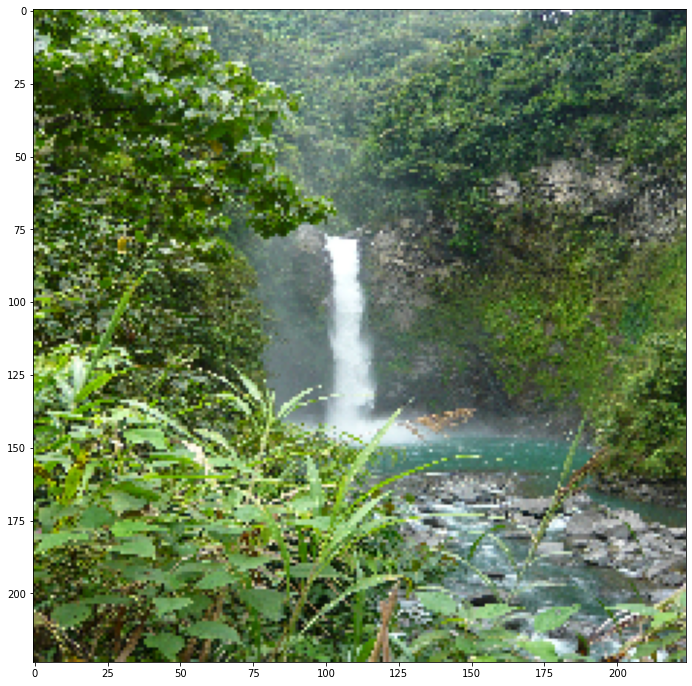

In [4]:
img_bgr = cv2.imread('jpg1/jpg/100200.jpg')
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# resize image
img = cv2.resize(img, (224, 224))
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)

# Definición de la función para el extractor CNN

A continuación, se definen dos funciones, la primera de ellas crea un modelo VGG16 para extraer las características de las imágenes. La segunda tiene la misma finalidad, pero utilizando una red ResNet.

In [5]:
from keras.applications.vgg16 import VGG16
from tensorflow.compat.v2.keras.applications.resnet50 import ResNet50
from keras.models import Model

def cnn_extractor_VGG16(img):
    """
    Extractor de caracteristicas de una imagen con una red resnet pre-entrenada

    :param numpy.ndarray img: imagen

    :return: el vector caracteristicas
    """
    # preprocess img
    img = cv2.resize(img,(224,224))
    img = np.reshape(img,[1,224,224,3]) # return the image with shaping that TF wants.

    model = VGG16(include_top=False,input_shape=( 224, 224, 3))
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # get extracted features
    features = model.predict(img)

    # 1x7x7x512 = 25088
    return np.array(features.flatten())

def cnn_extractor_ResNet50(img):
    """
    Extractor de caracteristicas de una imagen con una red resnet pre-entrenada

    :param numpy.ndarray img: imagen

    :return: el vector caracteristicas
    """
    # preprocess img
    img = cv2.resize(img,(224,224))
    img = np.reshape(img,[1,224,224,3]) # return the image with shaping that TF wants.

    model = ResNet50(include_top=False,input_shape=( 224, 224, 3))
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # get extracted features
    features = model.predict(img)

    return features.flatten()

# Definición de la función para el método Handcrafted

Nuevamente se definen dos funciones, en este caso, la primera corresponde a un extractor usando el histograma de la imagen, mientras que la segunda utiliza el histograma de gradiente (HOG).

In [6]:
def classic_extractor_histogram(img):
    """
    Extractor de caracteristicas de una imagen con metodos handcrafted

    :param numpy.ndarray img: imagen
    
    :return: el vector caracteristicas
    """
    #The Histogram of Oriented Gradient (HOG) feature descriptor

    # ajustamos el tamaño de la imagen
    resized_img = resize(img, (128*4, 64*4))

    #creating hog features
    histogram, bin_edges = np.histogram(img, bins=256)

    return np.array(histogram)
def classic_extractor_hog(img):
    """
    Extractor de caracteristicas de una imagen con metodos handcrafted

    :param numpy.ndarray img: imagen
    
    :return: el vector caracteristicas
    """
    #The Histogram of Oriented Gradient (HOG) feature descriptor

    # ajustamos el tamaño de la imagen
    resized_img = resize(img, (128*4, 64*4))

    #creating hog features
    feature, hog_img = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=True, multichannel=True)

    return feature

# 1) Cálculo de Vector de Característica

La siguiente función extrae el vector de características de una imagen según el tipo de extractor escogido.

In [7]:
def extract_features(img,tipo_extractor):
    """
    Extractor de caracteristicas de una imagen

    :param numpy.ndarray img: imagen
    :param str tipo_extractor: Tipo del extractor, puede ser clasico o CNN

    :return: el vector caracteristicas
    """
    if tipo_extractor == 'classic':
        features = classic_extractor_hog(img)
    elif tipo_extractor == 'CNN':
        features = cnn_extractor_VGG16(img)
    else:
        print('seleccione el tipo de extractor')
    return np.array(features)

## Se crean dos dataframes que guardarán los vectores de las imágenes de consulta y las de database.

In [8]:
img_query = pd.DataFrame(columns=['Name', 'Feature vector'])
img_database = pd.DataFrame(columns=['Name', 'Feature vector'])

## Aplicar el extractor a ambos conjuntos de INRIA y unir los resultados en los dataframes respectivos.

In [9]:
# Aplicar la extracción
path = glob.glob("jpg1//jpg//*.jpg")
for file in path:
  if file[14:16] == '00':
    img = cv2.imread(file)
    feature = extract_features(img,tipo_extractor='classic')
    img_query = img_query.append({'Name': file[10:16], 'Feature vector':feature}, ignore_index=True)
  else:
    img = cv2.imread(file)
    feature = extract_features(img,tipo_extractor='classic')
    img_database = img_database.append({'Name': file[10:16], 'Feature vector':feature}, ignore_index=True)

In [10]:
# Aplicar la extracción
path = glob.glob("jpg2//jpg//*.jpg")
for file in path:
  if file[14:16] == '00':
    img = cv2.imread(file)
    feature = extract_features(img,tipo_extractor='classic')
    img_query = img_query.append({'Name': file[10:16], 'Feature vector':feature}, ignore_index=True)
  else:
    img = cv2.imread(file)
    feature = extract_features(img,tipo_extractor='classic')
    img_database = img_database.append({'Name': file[10:16], 'Feature vector':feature}, ignore_index=True)

In [11]:
img_query.head()

,Name,Feature vector
0,103500,"[0.27289033786516415, 0.27289033786516415, 0.1..."
1,126100,"[0.18274533036832807, 0.02085426268101029, 0.0..."
2,118800,"[0.2884779280586252, 0.13186570822991367, 0.08..."
3,128800,"[0.24114246996444597, 0.047220838614507224, 0...."
4,127600,"[0.23617924116050745, 0.23617924116050745, 0.1..."


In [12]:
img_query.shape

(500, 2)

In [13]:
img_database.head()

,Name,Feature vector
0,114502,"[0.4102531055090311, 0.13086324711591962, 0.0,..."
1,123301,"[0.2704570357293412, 0.2704570357293412, 0.083..."
2,114903,"[0.26373369055797824, 0.26373369055797824, 0.0..."
3,128201,"[0.2251799535072163, 0.020750048574766422, 0.0..."
4,111801,"[0.24643441815501718, 0.06002427563830852, 0.0..."


In [14]:
img_database.shape

(991, 2)

# 2) Medida de similitud

In [15]:
from math import sqrt
def distancia_euclidiana(x,y):
    """
    Medida de similitud entre vectores de caracteristicas,
    usando la distancia euclidiana.

    :param numpy.ndarray x: primer vector
    :param numpy.ndarray y: segundo vector

    :return: la distancia euclidiana entre los vectores
    """
    suma = 0
    for xi,yi in zip(x,y):
        suma+= abs(xi-yi)**2
    return sqrt(suma)

In [16]:
# A continuación, se define una función que toma un vector (para la imagen de consulta, img_q) y un conjunto de vectores (para las imágenes de database, img_d)
# y aplica la distancia entre vectores, devolviendo un nuevo vector con estas medidas de similitud
def distance_vector(img_q, img_d):
  Distance_vector = []
  for i in range(len(img_d['Feature vector'])):
    Distance = distancia_euclidiana(img_q, img_d['Feature vector'].iloc[i])
    Distance_vector.append(Distance)
  return np.array(Distance_vector)

# 3) Ordenar resultados por relevancia

In [17]:
# La siguiente función recibe un conjunto de imágenes de consulta (img_q) y un conjunto de imágenes de una base de datos (img_d).
# Luego, aplica una medida de similitud entre cada imagen de consulta y todas las imágenes de database.
# Finalmente, entrega un frame con el nombre de la imagen consultada y el vector de distancia correspondiente obtenido.
def Comparacion(img_q, img_d):
  """
  Comparación entre los vectores de característica de las imágenes de consulta y las imágenes de database.

  :param img
  """
  comparacion = pd.DataFrame(columns=['Name_img_query', 'Distance Vector'])
  for i in range(len(img_q['Feature vector'])):
    d_v = distance_vector(img_q['Feature vector'].iloc[i], img_d)
    comparacion = comparacion.append({'Name_img_query': img_q['Name'].iloc[i], 'Distance Vector': d_v}, ignore_index=True)
  return comparacion

In [ ]:
# Aplicación de la función de comparación
comparision_frame = Comparacion(img_query, img_database)

In [ ]:
len(comparision_frame['Distance Vector'].iloc[0])

In [ ]:
comparision_frame.head()

# 4) Rank

In [ ]:
# La función rank, recibirá el nombre de una imagen de consulta con el formato 1-xxx-dd, donde
# xxx es la clase codificada y dd es el ID, y el conjunto de nombres de imágenes de database.
def rank(img_q, img_d):
  Nrel = 0 # Número de imágenes relevantes para una imagen de consulta particular (imágenes de la misma clase)
  R = [] # Posiciones de las imágenes con la misma clase
  SumaR = 0 # Suma de las posiciones relevantes
  for i in range(len(img_d)):
    if img_q[1:4] == (img_d.iloc[i])[1:4]:
      Nrel+=1
      R.append(i)
    else:
      pass
  for posicion in R:
    SumaR += posicion
  return (SumaR/Nrel)

In [ ]:
print(img_query['Name'][0])

In [ ]:
Rank = rank(img_query['Name'][0], img_database['Name'])

In [ ]:
def rank_frame(img_q, img_d):
  ranking_frame = pd.DataFrame(columns=['Name_img_query', 'Rank'])
  for i in range(len(img_q)):
    Rank = rank(img_q.iloc[i], img_d)
    ranking_frame = ranking_frame.append({'Name_img_query': img_q.iloc[i], 'Rank': Rank}, ignore_index=True)
  return ranking_frame

In [ ]:
ranking_frame = rank_frame(img_query['Name'], img_database['Name'])

In [ ]:
print(min(ranking_frame['Rank']), max(ranking_frame['Rank']))

In [ ]:
rank_copy = ranking_frame.copy()

In [ ]:
rank_copy.sort_values(by=['Rank'])

# 5) Rank Normalizado

In [ ]:
def rank_normalizado(img_q, img_d):
  Nrel = 0
  R = []
  N = len(img_d)
  Suma = 0
  for i in range(len(img_d)):
    if img_q[1:4] == (img_d.iloc[i])[1:4]:
      Nrel+=1
      R.append(i)
    else:
      pass
  Constant = Nrel*(Nrel+1)/2
  for i in range(len(R)):
    Suma += (R[i]-Constant)
  return (Suma/(Nrel*N))

In [ ]:
Rank_N = rank_normalizado(img_query['Name'][0], img_database['Name'])

In [ ]:
def rank_normalized_frame(img_q, img_d):
  ranking_N_frame = pd.DataFrame(columns=['Name_img_query', 'Rank'])
  for i in range(len(img_q)):
    Rank = rank_normalizado(img_q.iloc[i], img_d)
    ranking_N_frame = ranking_N_frame.append({'Name_img_query': img_q.iloc[i], 'Rank': Rank}, ignore_index=True)
  return ranking_N_frame

In [ ]:
ranking_Normalized_frame = rank_normalized_frame(img_query['Name'], img_database['Name'])

In [ ]:
ranking_Normalized_frame

# 6) Mostrar Resultados

In [ ]:
comparision_frame

In [ ]:
# La siguiente función recibe un arreglo de números y devuelve sus 10 valores mínimos junto a sus respectivas posiciones
def minimos_10(arr):
  arr_copy = arr.copy()
  arr_copy = sorted(arr_copy)
  minimos = arr_copy[0:10]
  posicion = []
  for numero in minimos:
    for i in range(len(arr)):
      if numero == arr[i] and ((i in posicion) == False):
        posicion.append(i)
      else: 
        pass
  return minimos, posicion

In [ ]:
L = [10,5,60,20,15,1,6,4,5,36,1,42,95,100,2,9]
m, p = minimos_10(L)
print(m,p)

In [ ]:
def imagenes_similares(img_q, comp_frame = comparision_frame, img_d = img_database):
  for i in range(len(comp_frame['Name_img_query'])):
    if img_q == comp_frame['Name_img_query'].iloc[i]:
      D_vector = comp_frame['Distance Vector'].iloc[i]
  m, p = minimos_10(D_vector)
  Name_imagenes = []
  for posiciones in p:
    Name_imagenes.append(img_d['Name'].iloc[posiciones])
  return Name_imagenes

In [ ]:
def plot_rank_10(img_q):
  L = imagenes_similares(img_q)
  try:
    img_bgr = cv2.imread('jpg1/jpg/' + img_q + '.jpg')
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img) 
    plt.axis('off') 
    plt.title("Imagen consultada: "+img_q)
  except:
    img_bgr = cv2.imread('jpg2/jpg/' + img_q + '.jpg')
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img) 
    plt.axis('off') 
    plt.title("Imagen consultada: "+img_q)


  fig = plt.figure(figsize=(15, 15))
  rows = 5
  columns = 2
  number = 1
  for name in L:
    try:
      fig.add_subplot(rows, columns, number)
      img_bgr = cv2.imread('jpg1/jpg/' + name + '.jpg')
      img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.axis('off') 
      plt.title("Imagen Rankeada: "+name+', posición '+ str(number))
      number+=1
    except:
      fig.add_subplot(rows, columns, number)
      img_bgr = cv2.imread('jpg2/jpg/' + name + '.jpg')
      img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.axis('off') 
      plt.title("Imagen Rankeada: "+name+', posición '+ str(number))
      number+=1

In [ ]:
plot_rank_10('123100')

In [ ]:
img_bgr = cv2.imread('jpg1/jpg/' + '123101' + '.jpg')
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img) 
plt.axis('off') 
plt.title("Imagen consultada: ")

In [ ]:
plot_rank_10('138700')

In [ ]:
plot_rank_10('142500')

# 7) Optimizaciones